<a href="https://colab.research.google.com/github/disha802/Graph-Based-Intelligence-for-Social-Good/blob/main/BDA_IA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install networkx matplotlib pandas numpy python-louvain scikit-learn node2vec tqdm

In [4]:
import os
import time
import gzip
import shutil
import urllib.request
from collections import defaultdict

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

import community as community_louvain

from tqdm import tqdm
from node2vec import Node2Vec

from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score


In [5]:
os.makedirs("dataset", exist_ok=True)
print("Dataset folder is ready.")


Dataset folder is ready.


In [6]:
youtube_edges_url = "https://snap.stanford.edu/data/bigdata/communities/com-youtube.ungraph.txt.gz"
youtube_communities_url = "https://snap.stanford.edu/data/bigdata/communities/com-youtube.all.cmty.txt.gz"

urllib.request.urlretrieve(youtube_edges_url, "dataset/youtube_edges.txt.gz")
urllib.request.urlretrieve(youtube_communities_url, "dataset/youtube_communities.txt.gz")

print("Download completed successfully!")


Download completed successfully!


In [7]:
def extract_gz(input_path, output_path):
    with gzip.open(input_path, "rb") as f_in:
        with open(output_path, "wb") as f_out:
            shutil.copyfileobj(f_in, f_out)

extract_gz("dataset/youtube_edges.txt.gz", "dataset/youtube_edges.txt")
extract_gz("dataset/youtube_communities.txt.gz", "dataset/youtube_communities.txt")

print("Extraction completed successfully!")


Extraction completed successfully!


In [8]:
G = nx.read_edgelist("dataset/youtube_edges.txt", nodetype=int)

print("Graph Loaded Successfully!")
print("Number of Nodes:", G.number_of_nodes())
print("Number of Edges:", G.number_of_edges())


Graph Loaded Successfully!
Number of Nodes: 1134890
Number of Edges: 2987624


In [9]:
avg_degree = sum(dict(G.degree()).values()) / G.number_of_nodes()

print("Average Degree:", avg_degree)
print("Graph Density:", nx.density(G))
print("Connected Components:", nx.number_connected_components(G))


Average Degree: 5.265045951590022
Graph Density: 4.639260713241579e-06
Connected Components: 1


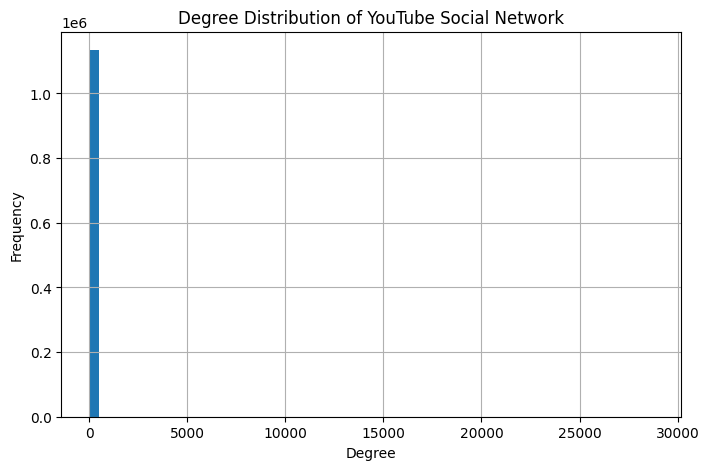

In [10]:
degrees = [deg for node, deg in G.degree()]

plt.figure(figsize=(8, 5))
plt.hist(degrees, bins=60)
plt.title("Degree Distribution of YouTube Social Network")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [11]:
start = time.time()
partition_louvain = community_louvain.best_partition(G)
end = time.time()

modularity_louvain = community_louvain.modularity(partition_louvain, G)

print("Louvain Community Detection Completed!")
print("Number of Communities:", len(set(partition_louvain.values())))
print("Modularity Score:", modularity_louvain)
print("Runtime (seconds):", round(end - start, 2))


Louvain Community Detection Completed!
Number of Communities: 5890
Modularity Score: 0.7216151620748592
Runtime (seconds): 327.43


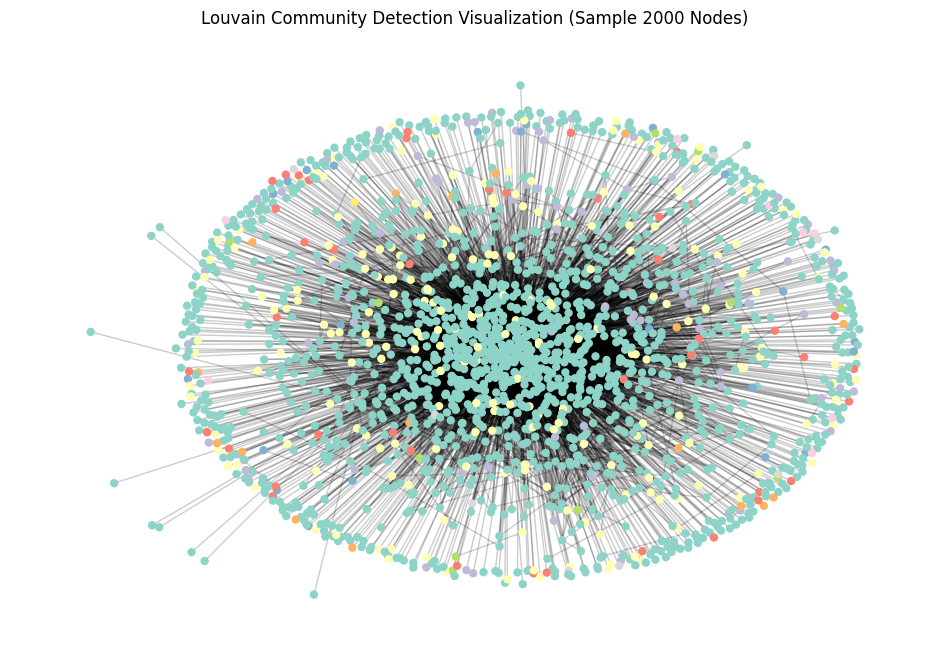

In [12]:
sample_nodes = list(G.nodes())[:2000]
subG = G.subgraph(sample_nodes)

sub_partition = {node: partition_louvain[node] for node in subG.nodes()}

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(subG, seed=42)

nx.draw_networkx_nodes(
    subG, pos,
    node_size=25,
    node_color=list(sub_partition.values()),
    cmap=plt.cm.Set3
)

nx.draw_networkx_edges(subG, pos, alpha=0.2)

plt.title("Louvain Community Detection Visualization (Sample 2000 Nodes)")
plt.axis("off")
plt.show()


In [13]:
true_labels = {}
community_id = 0

with open("dataset/youtube_communities.txt", "r") as f:
    for line in f:
        nodes = list(map(int, line.strip().split()))
        for node in nodes:
            true_labels[node] = community_id
        community_id += 1

print("Ground Truth Communities Loaded!")
print("Total Ground Truth Communities:", community_id)
print("Total Nodes with Ground Truth Labels:", len(true_labels))


Ground Truth Communities Loaded!
Total Ground Truth Communities: 16386
Total Nodes with Ground Truth Labels: 52675


In [14]:
common_nodes = list(set(G.nodes()).intersection(true_labels.keys()))

pred_louvain = [partition_louvain[node] for node in common_nodes]
true = [true_labels[node] for node in common_nodes]

nmi_louvain = normalized_mutual_info_score(true, pred_louvain)

print("NMI Score (Louvain vs Ground Truth):", nmi_louvain)


NMI Score (Louvain vs Ground Truth): 0.4371306563554307


In [15]:
sample_size = 3000  # adjust based on system power
nodes_subset = list(G.nodes())[:sample_size]
G_small = G.subgraph(nodes_subset)

print("Subgraph Ready!")
print("Nodes:", G_small.number_of_nodes())
print("Edges:", G_small.number_of_edges())


Subgraph Ready!
Nodes: 3000
Edges: 21688


In [16]:
node2vec = Node2Vec(
    G_small,
    dimensions=64,
    walk_length=30,
    num_walks=50,
    workers=4
)

start = time.time()
model = node2vec.fit(window=10, min_count=1, batch_words=4)
end = time.time()

print("Node2Vec Training Completed!")
print("Runtime (seconds):", round(end - start, 2))


Computing transition probabilities:   0%|          | 0/3000 [00:00<?, ?it/s]

Node2Vec Training Completed!
Runtime (seconds): 180.8


In [17]:
nodes_small = list(G_small.nodes())
X = np.array([model.wv[str(node)] for node in nodes_small])

print("Embedding Matrix Shape:", X.shape)


Embedding Matrix Shape: (3000, 64)


In [18]:
partition_louvain_small = community_louvain.best_partition(G_small)
k = len(set(partition_louvain_small.values()))

print("Number of clusters (k):", k)

start = time.time()
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X)
end = time.time()

print("KMeans Clustering Completed!")
print("Runtime (seconds):", round(end - start, 2))


Number of clusters (k): 8
KMeans Clustering Completed!
Runtime (seconds): 0.49


In [19]:
node_index = {node: i for i, node in enumerate(nodes_small)}
common_nodes_small = list(set(nodes_small).intersection(true_labels.keys()))

pred_kmeans = [cluster_labels[node_index[node]] for node in common_nodes_small]
true_small = [true_labels[node] for node in common_nodes_small]

nmi_kmeans = normalized_mutual_info_score(true_small, pred_kmeans)

print("NMI Score (Node2Vec + KMeans vs Ground Truth):", nmi_kmeans)


NMI Score (Node2Vec + KMeans vs Ground Truth): 0.3975908672598444


In [20]:
results = pd.DataFrame({
    "Method": ["Louvain", "Node2Vec + KMeans"],
    "NMI Score": [nmi_louvain, nmi_kmeans],
    "Dataset Used": ["Full Graph", f"Subgraph ({sample_size} nodes)"]
})

results


,Method,NMI Score,Dataset Used
0,Louvain,0.437131,Full Graph
1,Node2Vec + KMeans,0.397591,Subgraph (3000 nodes)


In [21]:
community_nodes = defaultdict(list)

for node, comm in partition_louvain.items():
    community_nodes[comm].append(node)

print("Total Louvain Communities:", len(community_nodes))


Total Louvain Communities: 5890


In [22]:
community_profile = []

for comm, nodes_in_comm in tqdm(community_nodes.items()):
    sub = G.subgraph(nodes_in_comm)

    size = sub.number_of_nodes()
    internal_edges = sub.number_of_edges()
    density = nx.density(sub)

    external_edges = 0
    for node in nodes_in_comm:
        for neigh in G.neighbors(node):
            if neigh not in sub:
                external_edges += 1

    community_profile.append([comm, size, internal_edges, external_edges, density])

community_df = pd.DataFrame(
    community_profile,
    columns=["CommunityID", "Size", "InternalEdges", "ExternalEdges", "Density"]
)

community_df.sort_values("Size", ascending=False).head(10)

100%|██████████| 5890/5890 [00:17<00:00, 342.78it/s] 


,CommunityID,Size,InternalEdges,ExternalEdges,Density
0,0,195302,453914,217249,0.000024
1,1,133003,496839,183872,0.000056
10,10,99061,262622,79658,0.000054
9,9,97612,364776,84290,0.000077
15,15,61090,133318,88219,0.000071
13,13,50942,70138,22689,0.000054
8,8,39746,65812,39275,0.000083
24,24,38527,122718,25550,0.000165
29,29,30118,38320,20514,0.000084
5,5,24875,29966,18537,0.000097


In [23]:
pagerank = nx.pagerank(G)
print("PageRank computed successfully!")


PageRank computed successfully!


In [24]:
risk_scores = []

for comm, nodes_in_comm in tqdm(community_nodes.items()):
    sub = G.subgraph(nodes_in_comm)

    density = nx.density(sub)
    internal_edges = sub.number_of_edges()
    size = sub.number_of_nodes()

    pr_values = [pagerank[n] for n in nodes_in_comm]
    pr_variance = np.var(pr_values)

    # Novel Risk Score Formula
    risk = (density * np.log1p(internal_edges)) + (10 * pr_variance)

    risk_scores.append([comm, risk, pr_variance])

risk_df = pd.DataFrame(
    risk_scores,
    columns=["CommunityID", "RiskScore", "PageRankVariance"]
)

final_df = community_df.merge(risk_df, on="CommunityID")
final_df.sort_values("RiskScore", ascending=False).head(10)


100%|██████████| 5890/5890 [00:12<00:00, 485.34it/s] 


,CommunityID,Size,InternalEdges,ExternalEdges,Density,RiskScore,PageRankVariance
1920,1924,11,37,5,0.672727,2.447103,1.648159e-13
4735,4739,5,10,1,1.000000,2.397895,4.747281e-16
3359,3363,9,24,6,0.666667,2.145917,1.432888e-13
4031,4035,5,9,3,0.900000,2.072327,5.735433e-14
3407,3411,6,12,2,0.800000,2.051959,1.050292e-13
5099,5103,4,6,1,1.000000,1.945910,8.443586e-15
1946,1950,4,6,2,1.000000,1.945910,5.928540e-15
4623,4627,4,6,1,1.000000,1.945910,5.381213e-15
1719,1723,4,6,2,1.000000,1.945910,4.102107e-15
1906,1910,4,6,2,1.000000,1.945910,3.513661e-15


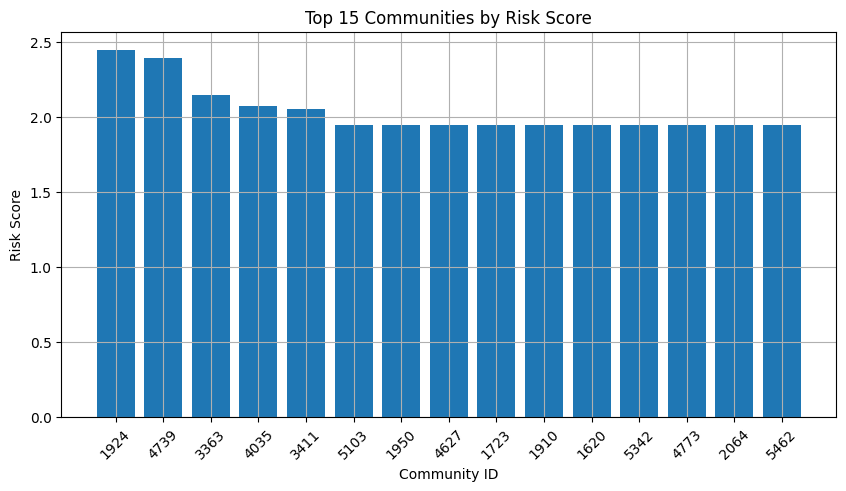

In [25]:
top_risk = final_df.sort_values("RiskScore", ascending=False).head(15)

plt.figure(figsize=(10, 5))
plt.bar(top_risk["CommunityID"].astype(str), top_risk["RiskScore"])
plt.title("Top 15 Communities by Risk Score")
plt.xlabel("Community ID")
plt.ylabel("Risk Score")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


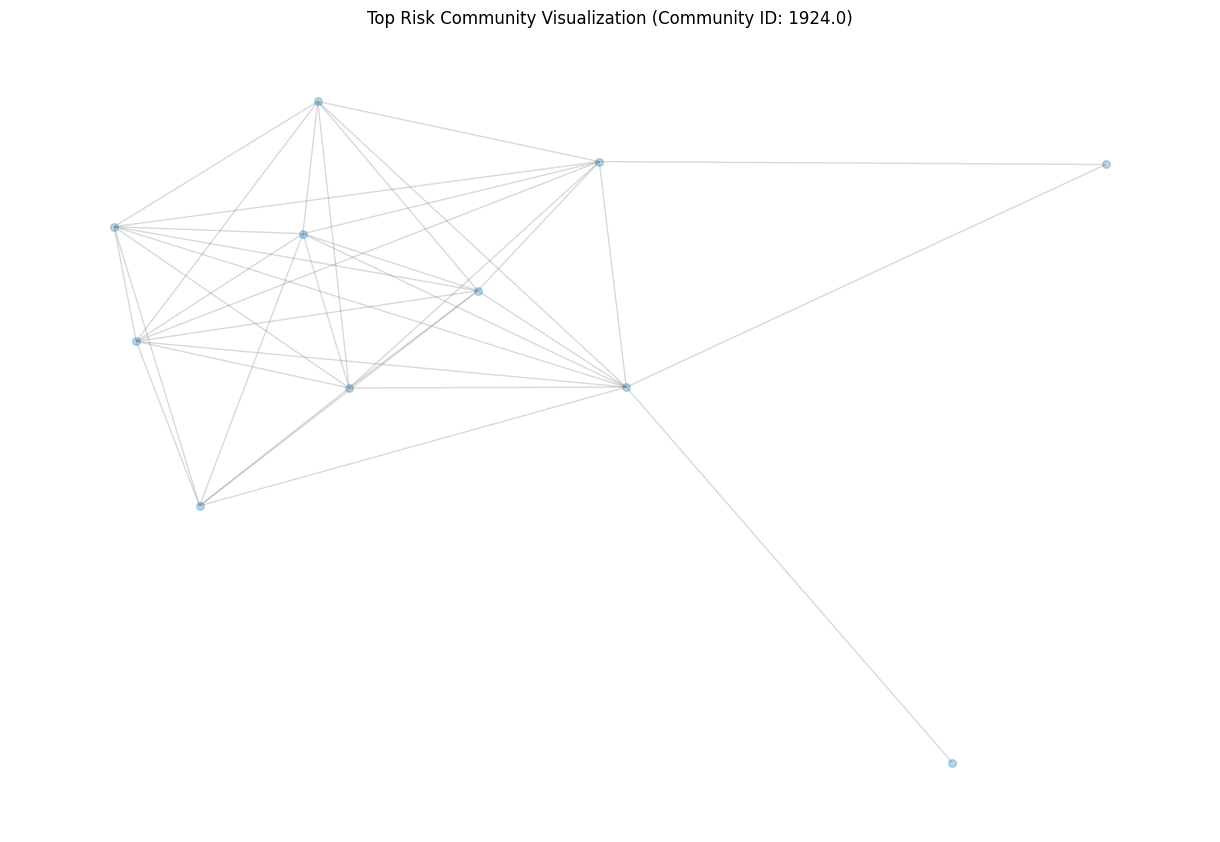

In [26]:
top_comm = final_df.sort_values("RiskScore", ascending=False).iloc[0]["CommunityID"]
top_nodes = community_nodes[top_comm]

sub_top = G.subgraph(top_nodes[:500])  # limit for plotting

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(sub_top, seed=42)

nx.draw(sub_top, pos, node_size=30, edge_color="gray", alpha=0.3)
plt.title(f"Top Risk Community Visualization (Community ID: {top_comm})")
plt.axis("off")
plt.show()


In [27]:
fractions = [0.1, 0.3, 0.5, 1.0]
nodes_list = list(G.nodes())

scalability_results = []

for frac in fractions:
    sample_count = int(len(nodes_list) * frac)
    sampled_nodes = nodes_list[:sample_count]
    SG = G.subgraph(sampled_nodes)

    start = time.time()
    part = community_louvain.best_partition(SG)
    modularity = community_louvain.modularity(part, SG)
    end = time.time()

    scalability_results.append([
        frac,
        SG.number_of_nodes(),
        SG.number_of_edges(),
        modularity,
        end - start
    ])

scalability_df = pd.DataFrame(
    scalability_results,
    columns=["Fraction", "Nodes", "Edges", "Modularity", "RuntimeSeconds"]
)

scalability_df


,Fraction,Nodes,Edges,Modularity,RuntimeSeconds
0,0.1,113489,786231,0.567041,38.846202
1,0.3,340467,1762046,0.641843,146.577411
2,0.5,567445,2247935,0.671345,277.727648
3,1.0,1134890,2987624,0.722729,370.176770


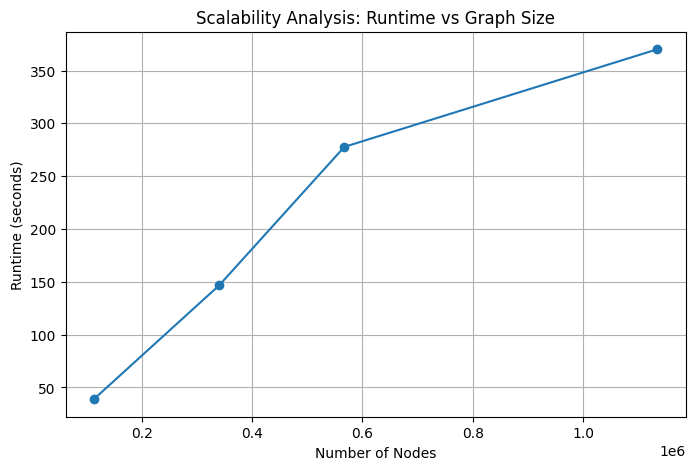

In [28]:
plt.figure(figsize=(8, 5))
plt.plot(scalability_df["Nodes"], scalability_df["RuntimeSeconds"], marker="o")
plt.xlabel("Number of Nodes")
plt.ylabel("Runtime (seconds)")
plt.title("Scalability Analysis: Runtime vs Graph Size")
plt.grid(True)
plt.show()


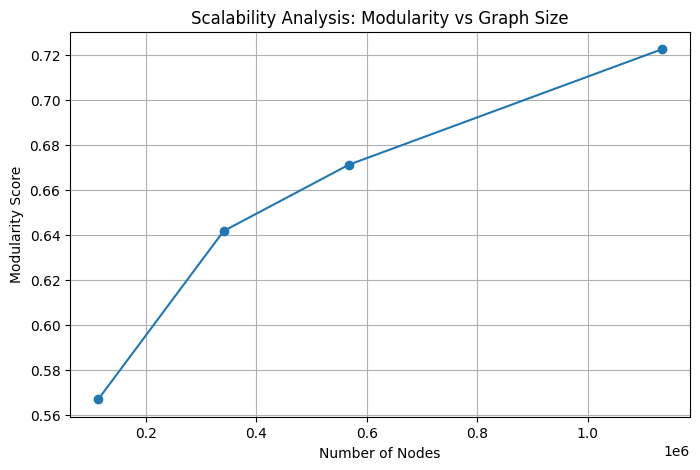

In [29]:
plt.figure(figsize=(8, 5))
plt.plot(scalability_df["Nodes"], scalability_df["Modularity"], marker="o")
plt.xlabel("Number of Nodes")
plt.ylabel("Modularity Score")
plt.title("Scalability Analysis: Modularity vs Graph Size")
plt.grid(True)
plt.show()

In [30]:
results.to_csv("results_method_comparison.csv", index=False)
final_df.to_csv("results_community_risk_scores.csv", index=False)
scalability_df.to_csv("results_scalability.csv", index=False)

print("All result tables exported successfully!")


All result tables exported successfully!


In [31]:
print("===== FINAL SUMMARY =====")
print("Graph Nodes:", G.number_of_nodes())
print("Graph Edges:", G.number_of_edges())
print("Louvain Communities:", len(set(partition_louvain.values())))
print("Louvain Modularity:", modularity_louvain)
print("Louvain NMI:", nmi_louvain)
print("Node2Vec+KMeans NMI:", nmi_kmeans)
print("=========================")


===== FINAL SUMMARY =====
Graph Nodes: 1134890
Graph Edges: 2987624
Louvain Communities: 5890
Louvain Modularity: 0.7216151620748592
Louvain NMI: 0.4371306563554307
Node2Vec+KMeans NMI: 0.3975908672598444
